<a href="https://colab.research.google.com/github/Huxwell/ColabNNs/blob/main/cats_n_dogs_create_hybrids_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import torch.nn as nn
import torch
# import torch.optim as optim
# import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import glob
# from tqdm import tqdm
from PIL import Image
import random # do random.seed(13) before every shuffle. order of shuffle() execution changes results order.

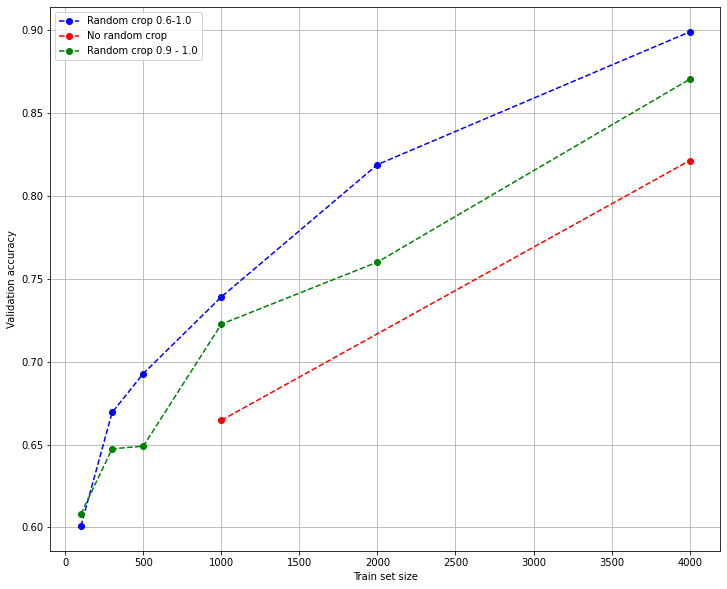

In [2]:
plt.figure(figsize=(12,10))
# plt.plot([100, 300, 500, 1000, 2000, 4000, 15000],[0.6008, 0.6693, 0.692799,  0.739, 0.8188, 0.8988, 0.9506],'--bo', label="Random crop 0.6-1.0")
plt.plot([100, 300, 500, 1000, 2000, 4000],[0.6008, 0.6693, 0.692799,  0.739, 0.8188, 0.8988],'--bo', label="Random crop 0.6-1.0") #don't show last one full train set; just ease of reading the plot
plt.plot([1000, 4000],[0.6646, 0.8212],'--ro', label="No random crop")
plt.plot([100,300,500,1000,2000,4000],[0.6080,0.6474,0.649,0.7226,0.76,0.8702],'--go',  label="Random crop 0.9 - 1.0")
plt.legend()
plt.grid()
plt.xlabel('Train set size')
plt.ylabel('Validation accuracy')
plt.show()

In [3]:
dataset_dir = '/content/drive/MyDrive/cats_n_dogs_unsure/dogs-vs-cats-redux-kernels-edition'
os.listdir(dataset_dir)

['sample_submission.csv', 'test.zip', 'train.zip']

In [4]:
os.makedirs('local_data/', exist_ok=True)
train_dir = 'local_data/train'

In [5]:
with zipfile.ZipFile(os.path.join(dataset_dir, 'train.zip')) as train_zip:
    train_zip.extractall('local_data')

In [6]:
os.listdir(train_dir)[:5]

['cat.5581.jpg',
 'cat.8006.jpg',
 'dog.2946.jpg',
 'dog.1689.jpg',
 'dog.9509.jpg']

In [7]:
cats_list = sorted(glob.glob(os.path.join(train_dir,'cat*.jpg')))
dogs_list = sorted(glob.glob(os.path.join(train_dir,'dog*.jpg')))
print(len(cats_list))
print(len(dogs_list))
random.seed(13)
random.shuffle(cats_list)
random.seed(13) #multiple seed() executions are on purpose.
random.shuffle(dogs_list)
print(cats_list[:3])
print(dogs_list[:3])
# some sanity check to make sure no uncontrolled randomness beyond this point
assert cats_list[2] == 'local_data/train/cat.801.jpg'
assert dogs_list[2] == 'local_data/train/dog.801.jpg'
assert len(cats_list) == len(dogs_list)


12500
12500
['local_data/train/cat.8473.jpg', 'local_data/train/cat.3808.jpg', 'local_data/train/cat.801.jpg']
['local_data/train/dog.8473.jpg', 'local_data/train/dog.3808.jpg', 'local_data/train/dog.801.jpg']


In [8]:
full_train_list = cats_list[:7500] + dogs_list[:7500]
subset_train_list = cats_list[:2000] + dogs_list[:2000]
# subset_train_list = cats_list[:250] + dogs_list[:250]
val_list = cats_list[7500:10000] + dogs_list[7500:10000]
test_list = cats_list[10000:] + dogs_list[10000:]
print(len(full_train_list), len(val_list), len(test_list))

random.seed(13)
random.shuffle(full_train_list)
random.seed(13)
random.shuffle(subset_train_list)
random.seed(13)
random.shuffle(val_list)
random.seed(13)
random.shuffle(test_list)
print("full",full_train_list[:9])
print("subset",subset_train_list[:9])
print("val",val_list[:9])
print("test",test_list[:9])
assert full_train_list[4] == 'local_data/train/cat.1612.jpg'
# assert subset_train_list[4] == 'local_data/train/cat.1787.jpg' #500imgs train
assert subset_train_list[4] == 'local_data/train/cat.5360.jpg' #4000 imgs train
# assert subset_train_list[4] == 'local_data/train/dog.11151.jpg'#2000imgs train
assert val_list[4] == 'local_data/train/dog.12023.jpg'
assert test_list[4] == 'local_data/train/dog.6485.jpg'

15000 5000 5000
full ['local_data/train/dog.599.jpg', 'local_data/train/dog.1470.jpg', 'local_data/train/cat.682.jpg', 'local_data/train/dog.7470.jpg', 'local_data/train/cat.1612.jpg', 'local_data/train/cat.5301.jpg', 'local_data/train/dog.8695.jpg', 'local_data/train/cat.210.jpg', 'local_data/train/dog.10388.jpg']
subset ['local_data/train/cat.457.jpg', 'local_data/train/dog.7392.jpg', 'local_data/train/cat.1909.jpg', 'local_data/train/dog.9125.jpg', 'local_data/train/cat.5360.jpg', 'local_data/train/dog.5395.jpg', 'local_data/train/dog.996.jpg', 'local_data/train/dog.12418.jpg', 'local_data/train/cat.3258.jpg']
val ['local_data/train/dog.586.jpg', 'local_data/train/dog.1669.jpg', 'local_data/train/cat.1066.jpg', 'local_data/train/dog.5798.jpg', 'local_data/train/dog.12023.jpg', 'local_data/train/cat.10748.jpg', 'local_data/train/cat.1815.jpg', 'local_data/train/dog.5218.jpg', 'local_data/train/dog.5240.jpg']
test ['local_data/train/dog.1856.jpg', 'local_data/train/dog.10017.jpg', 'lo

In [9]:
# train_list = subset_train_list # 5 batches # or 20 batches
train_list = full_train_list

[ 9511  7110  9104  7890  5456 10705  7373  4795 10884  1667]


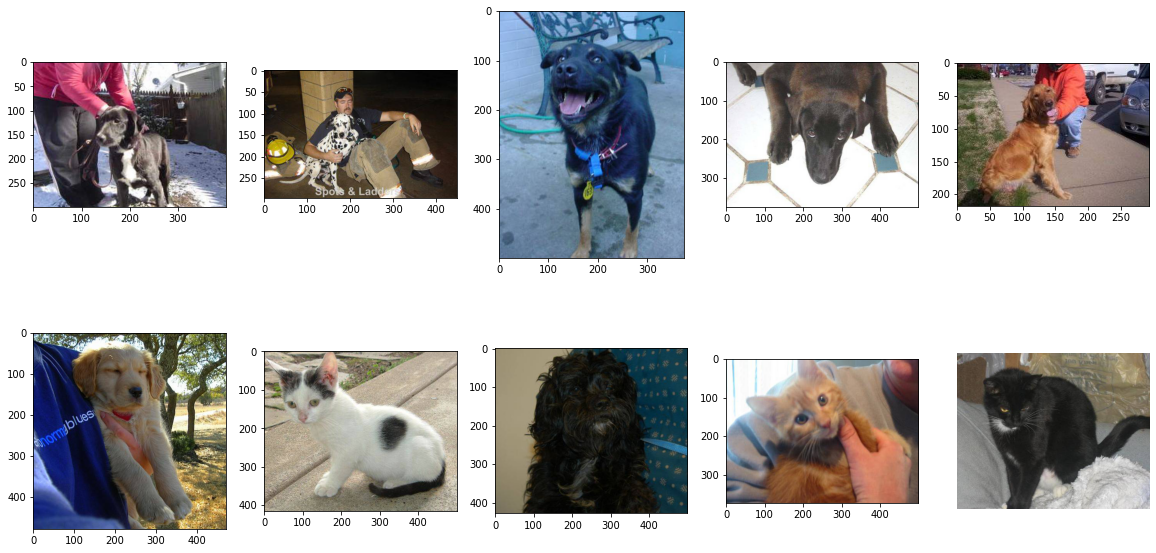

In [10]:
np.random.seed(1313131313)
random_idx = np.random.randint(1,len(train_list),size=10)
print(random_idx)
fig = plt.figure(figsize=(20., 10.))

for i, img_idx in enumerate(random_idx):
    ax = fig.add_subplot(2,5,i+1)
    img = Image.open(train_list[img_idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

[ 9511  7110  9104  7890  5456 10705  7373  4795 10884  1667]
<class 'PIL.JpegImagePlugin.JpegImageFile'>
local_data/train/dog.10678.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
local_data/train/dog.9582.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
local_data/train/dog.2589.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
local_data/train/dog.3780.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
local_data/train/dog.7123.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
local_data/train/dog.3249.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
local_data/train/cat.3.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
local_data/train/dog.2292.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
local_data/train/cat.8740.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
local_data/train/cat.11476.jpg


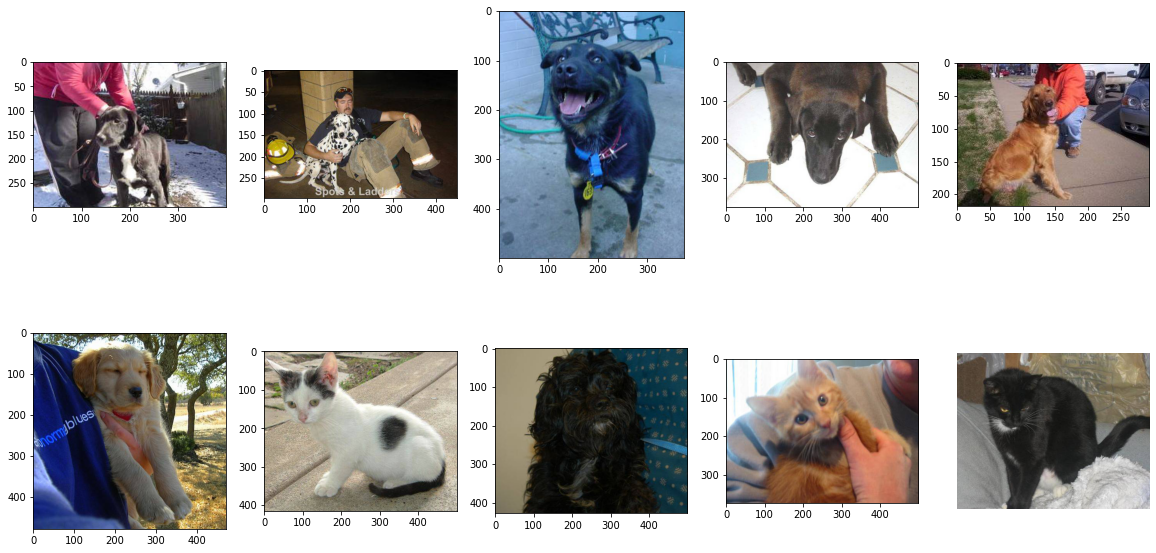

In [11]:
np.random.seed(1313131313)
random_idx = np.random.randint(1,len(train_list),size=10)
print(random_idx)
fig = plt.figure(figsize=(20., 10.))

for i, img_idx in enumerate(random_idx):
    ax = fig.add_subplot(2,5,i+1)
    img = Image.open(train_list[img_idx])
    print(type(img))
    print(train_list[img_idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

(300, 399, 3)


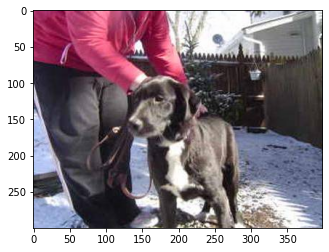

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline  # if you are running this code in Jupyter notebook

# reads image 'opencv-logo.png' as grayscale
img = cv2.imread('local_data/train/dog.10678.jpg')[...,::-1] #same as [:,:,::-1]; opencv reads in bgr, but matplotlib uses rgb
plt.imshow(img)
print(img.shape)

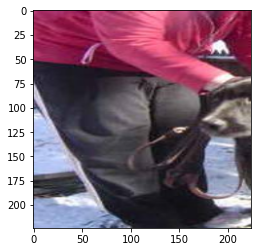

In [13]:
plt.imshow(cv2.resize(img[:,:170,:],[224,224]))

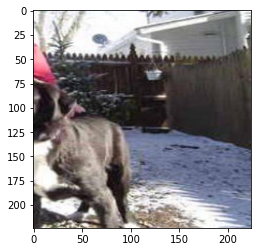

In [14]:
plt.imshow(cv2.resize(img[:,190:,:],[224,224]))

[ 9511  7110  9104  7890  5456 10705  7373  4795 10884  1667]


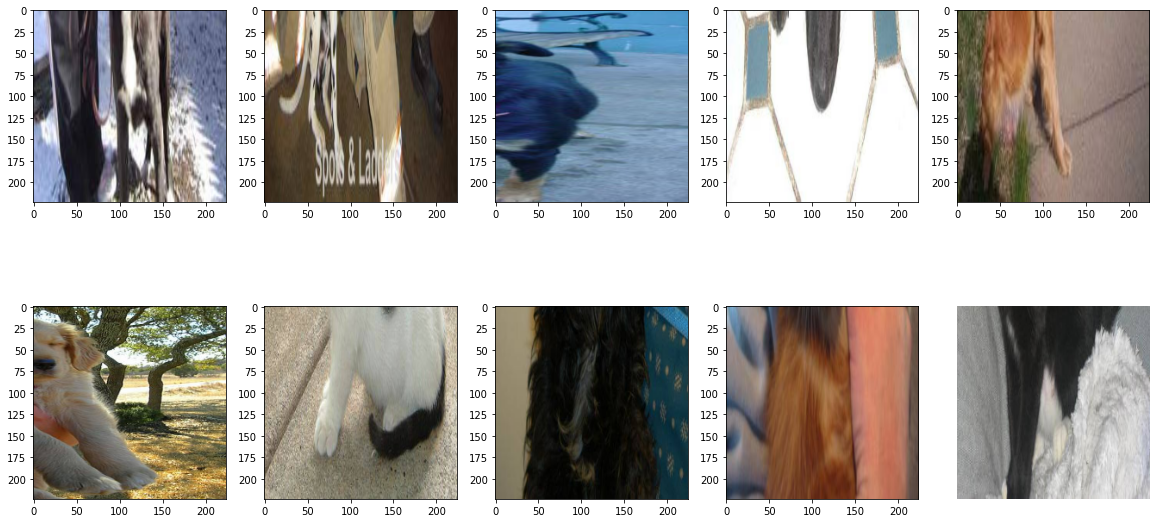

In [15]:
np.random.seed(1313131313)
random_idx = np.random.randint(1,len(train_list),size=10)
print(random_idx)
fig = plt.figure(figsize=(20., 10.))

for i, img_idx in enumerate(random_idx):
    ax = fig.add_subplot(2,5,i+1)
    img = cv2.imread(train_list[img_idx])[...,::-1] #same as [:,:,::-1]; opencv reads in bgr, but matplotlib uses rgb
    h,w,c = img.shape
    if h > w:
      h = int(0.5 * h)
      img = img[:,h:,:]
    else:
      w = int(0.5 * w)
      img = img[w:,:,:]

    img = cv2.resize(img,[224,224])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

[ 9511  7110  9104  7890  5456 10705  7373  4795 10884  1667]


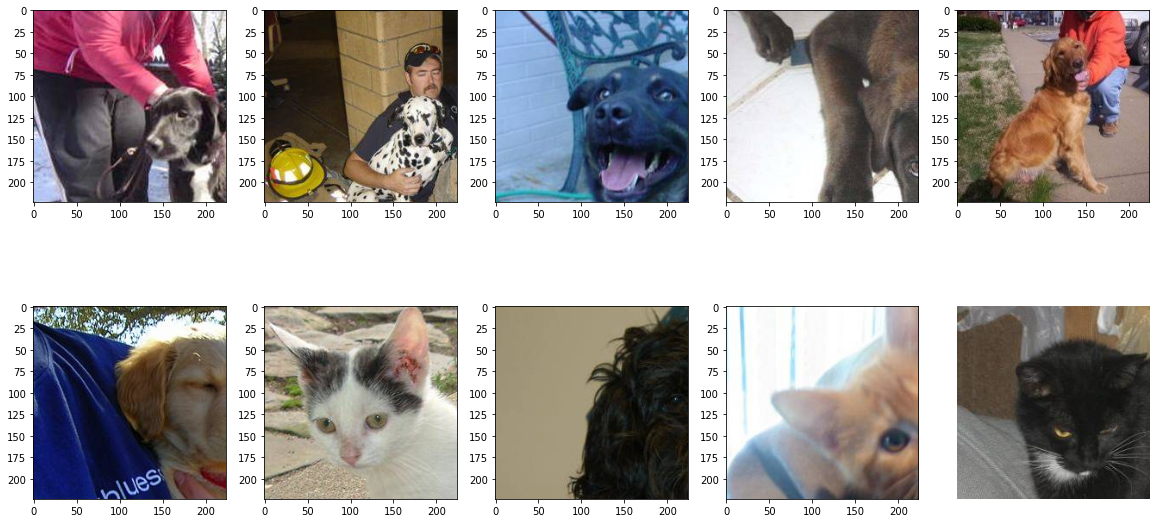

In [16]:
np.random.seed(1313131313)
random_idx = np.random.randint(1,len(train_list),size=10)
print(random_idx)
fig = plt.figure(figsize=(20., 10.))

for i, img_idx in enumerate(random_idx):
    ax = fig.add_subplot(2,5,i+1)
    img = cv2.imread(train_list[img_idx])[...,::-1] #same as [:,:,::-1]; opencv reads in bgr, but matplotlib uses rgb
    h,w,c = img.shape
    img = img[:224,:224,:]


    img = cv2.resize(img,[224,224])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [17]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [18]:
## Visualization of Image Classification 
import torchvision
def visualize_classification(loader_iter, nrofItems = 9, pad = 0) -> None:

  #Iterate through the data loader
  imgTensor, labels = next(loader_iter)
  labels = labels.tolist()

  # Generate image grid
  grid = torchvision.utils.make_grid(imgTensor[:nrofItems], padding = pad, nrow=nrofItems)

  # Permute the axis as numpy expects image of shape (H x W x C) 
  grid = grid.permute(1, 2, 0)
  
  # Set up plot config
  plt.figure(figsize=(8, 2), dpi=300)
  plt.axis('off')

  # Plot Image Grid
  plt.imshow(grid)
  
  # # Plot the image titles
  # fact = 1 + (nrofItems)/100
  # rng = np.linspace(1/(fact*nrofItems), 1 - 1/(fact*nrofItems) , num = nrofItems)
  # for idx, val in enumerate(rng):
  #   plt.figtext(val, 0.85, labels[idx], fontsize=8)

  # Show the plot
  plt.show()

In [19]:
train_transforms =  transforms.Compose([ #these params work well for cats & dogs.:
  # transforms.Resize((224, 224)),
  transforms.RandomResizedCrop(224,scale=(0.2, 0.4)), 
  # transforms.RandomHorizontalFlip(),
  # transforms.ColorJitter(brightness=.4, hue=.15),
  transforms.ToTensor(),
])

In [20]:
batch_size=10
train_data = dataset(train_list, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=False )


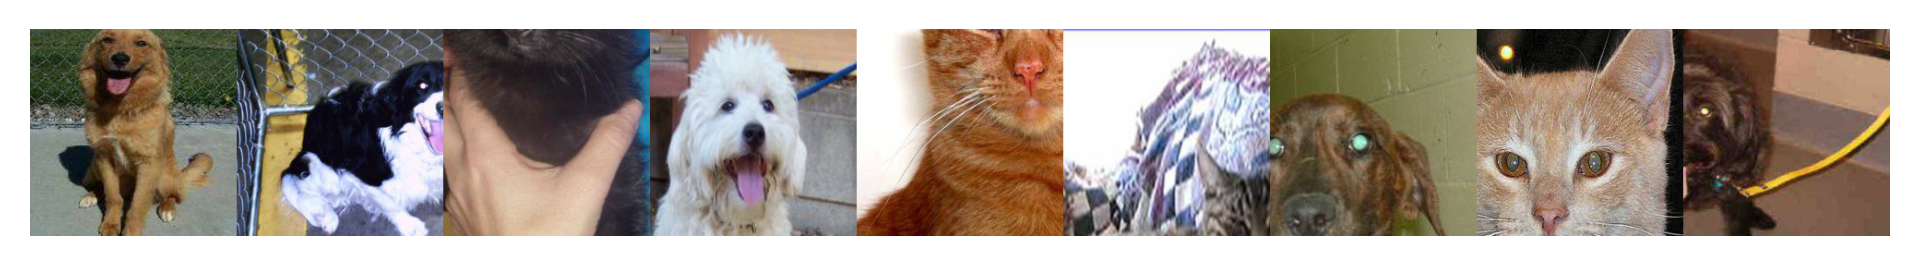

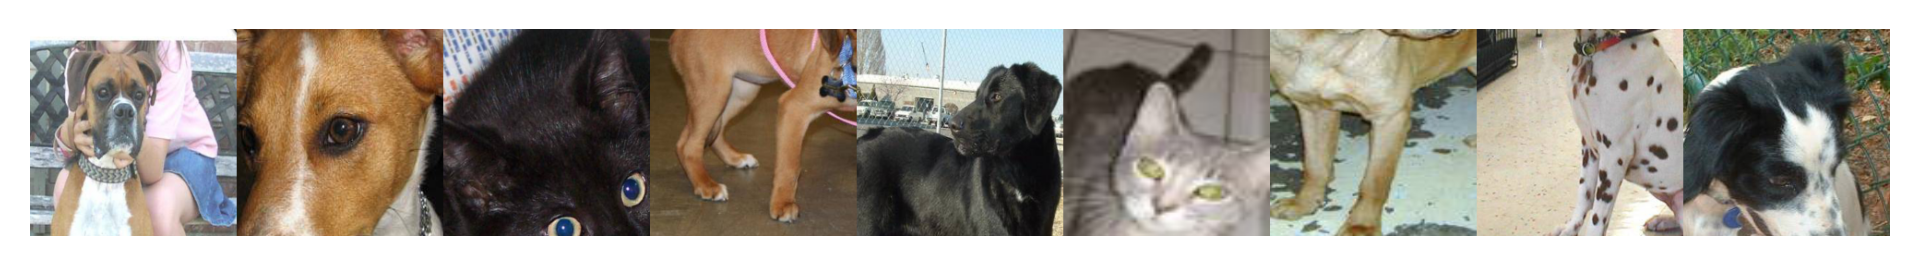

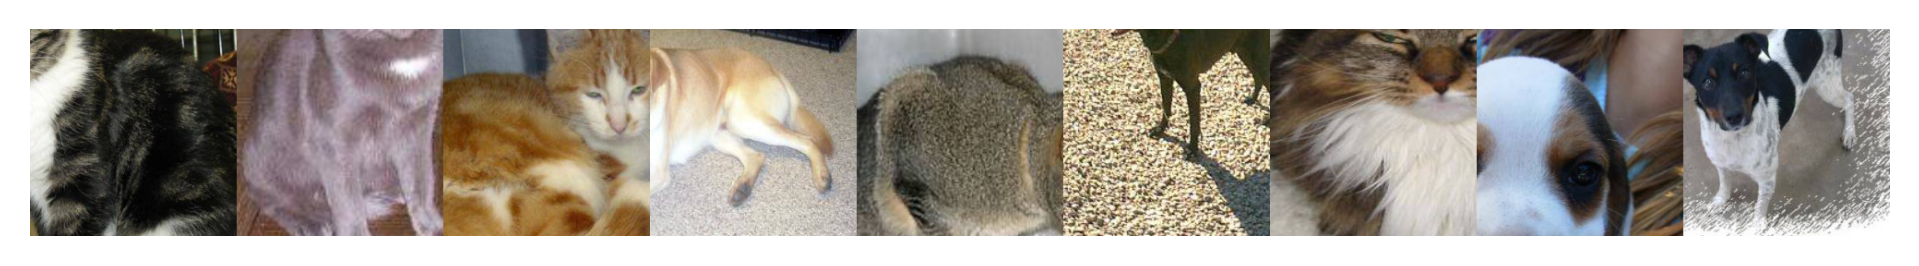

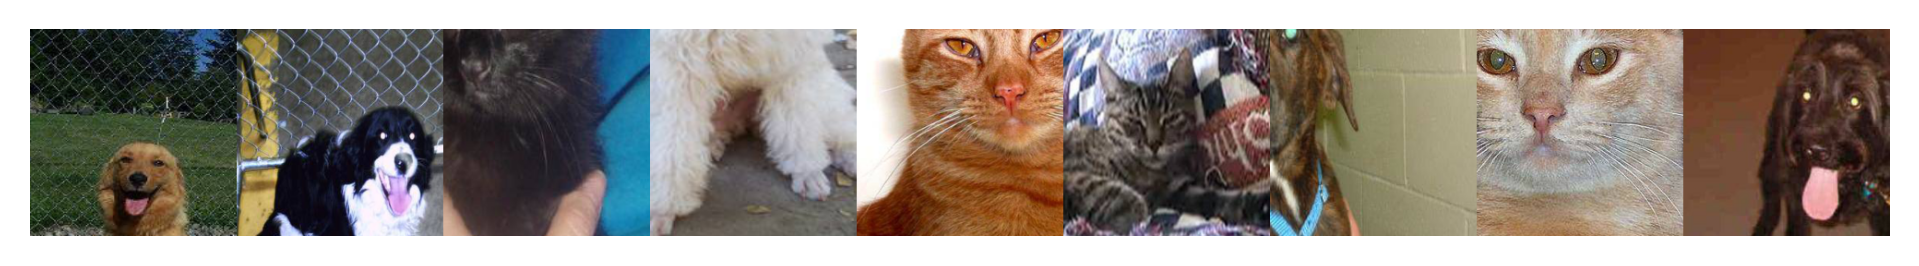

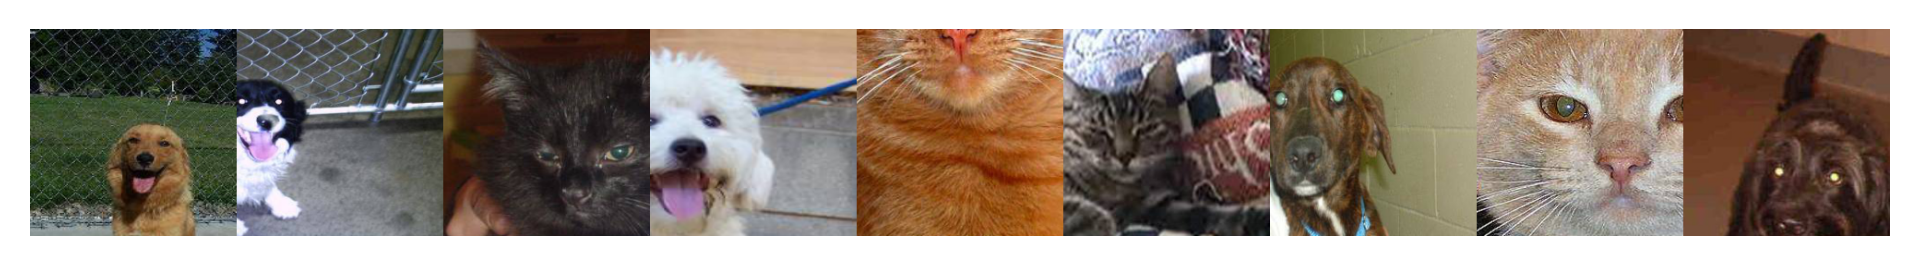

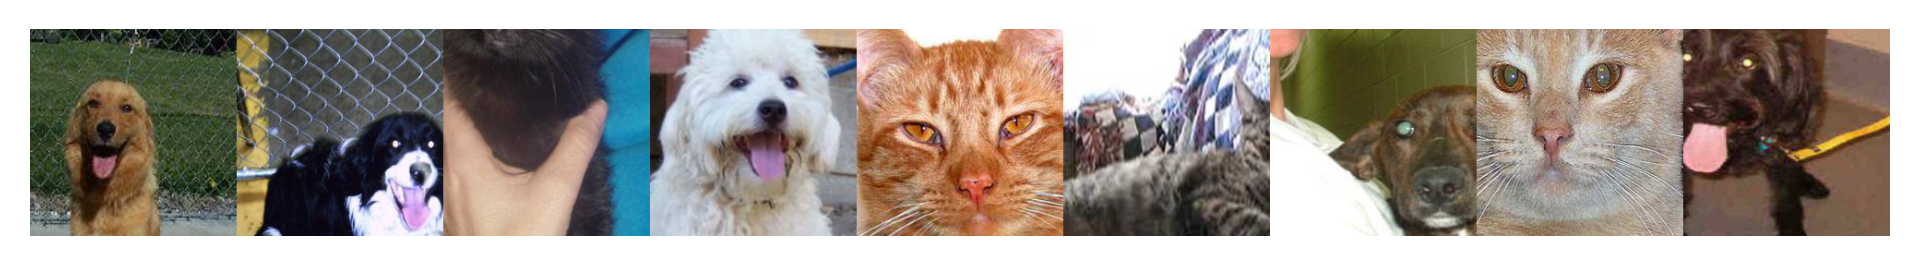

In [21]:
# this cell is here only because the Author apprently didn't understand how Dataset and Dataloaders behave - are they iterable, are they generators? - well they are hybrid. - , and wanted to see what happens
# all but one cell can be commented
# TODO: you don't need a separate loader. each iteration goes from the beginning
# but its interesting that different augmentations get generated.
iterator = iter(train_loader)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iterator)
visualize_classification(iter(train_loader))
visualize_classification(iter(train_loader))
visualize_classification(iter(train_loader))

# This was exploration code, now write a snipper that will actually save the imgs

In [34]:
from tqdm import tqdm
from torchvision.utils import save_image

batch_size=1
train_data = dataset(train_list, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=False )


epochs = 1 #10
max = 200
os.makedirs('generated/', exist_ok=True)

for epoch in range(epochs):
    print("\n","="*30,"\n")
    epoch_loss = 0
    epoch_accuracy = 0
    
    with tqdm(train_loader, unit="iteration") as tepoch:      
      for id, (data, label) in enumerate(tepoch):
        save_image(data,f"generated/{id}_{label.item()}.png")
        tepoch.set_description(f"Generating transformed images, epoch {epoch}, iteration {id}")
        if id >= max:
          break

    #       tepoch.set_postfix(loss=loss.item(), accuracy=100. * epoch_accuracy)
    #   print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch, epoch_accuracy,epoch_loss))
    # print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch, epoch_val_accuracy,epoch_val_loss))


Generating transformed images, epoch 0, iteration 200:   1%|▏         | 200/15000 [00:06<08:32, 28.89iteration/s]
